In [ ]:
import os
import logging
from pathlib import Path

LOG_DIR = "../../logs"
os.makedirs(LOG_DIR, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(f"{LOG_DIR}/yolo_from_voc.log"),
        logging.StreamHandler(),
    ],
)

logger = logging.getLogger(__name__)
logger.info("YOLOv8 training from VOC dataset started")

2026-01-31 19:11:55,515 | INFO | YOLOv8 training from VOC dataset started


In [ ]:
from pathlib import Path

# Input dataset (VOC format)
DATA_ROOT = Path("../../India")
IMG_DIR = DATA_ROOT / "train" / "images"
XML_DIR = DATA_ROOT / "train" / "annotations" / "xmls"

assert IMG_DIR.exists()
assert XML_DIR.exists()

# Output YOLO dataset
YOLO_ROOT = Path("datasets/yolo_rdd")

In [3]:
# Final class mapping
CLASS_GROUPS = {
    "crack": ["D00", "D01", "D10"],
    "road_damage": ["D20", "D40"],
    "pothole": ["D11"],
    "manhole": ["D44"],
    "other": ["D50"],
}

CLASS_TO_ID = {
    "crack": 0,
    "road_damage": 1,
    "pothole": 2,
    "manhole": 3,
    "other": 4,
}

VOC_TO_GROUP = {}
for group, voc_list in CLASS_GROUPS.items():
    for voc in voc_list:
        VOC_TO_GROUP[voc] = CLASS_TO_ID[group]

NUM_CLASSES = 5
logger.info("Using %d classes: %s", NUM_CLASSES, CLASS_TO_ID)

2026-01-31 19:11:55,527 | INFO | Using 5 classes: {'crack': 0, 'road_damage': 1, 'pothole': 2, 'manhole': 3, 'other': 4}


In [4]:
for split in ["train", "val"]:
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

logger.info("YOLO directory structure ready at %s", YOLO_ROOT)

2026-01-31 19:11:55,534 | INFO | YOLO directory structure ready at datasets/yolo_rdd


In [5]:
import random

SEED = 42
VAL_RATIO = 0.2

image_files = sorted(IMG_DIR.glob("*.jpg"))
assert len(image_files) > 0

random.seed(SEED)
random.shuffle(image_files)

val_count = int(len(image_files) * VAL_RATIO)

val_images = set(image_files[:val_count])
train_images = set(image_files[val_count:])

logger.info("Total images: %d", len(image_files))
logger.info("Train images: %d | Val images: %d", len(train_images), len(val_images))

2026-01-31 19:11:55,577 | INFO | Total images: 7706
2026-01-31 19:11:55,578 | INFO | Train images: 6165 | Val images: 1541


In [6]:
import xml.etree.ElementTree as ET
import cv2

def convert_voc_to_yolo(xml_path, img_path, out_txt):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img = cv2.imread(str(img_path))
    if img is None:
        return False

    h, w = img.shape[:2]
    yolo_lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        if name not in VOC_TO_GROUP:
            continue

        cls_id = VOC_TO_GROUP[name]
        bnd = obj.find("bndbox")

        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)

        # Convert to YOLO normalized format
        xc = ((xmin + xmax) / 2) / w
        yc = ((ymin + ymax) / 2) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        # Assertions (CRITICAL)
        assert 0 < bw <= 1
        assert 0 < bh <= 1
        assert 0 <= xc <= 1
        assert 0 <= yc <= 1

        yolo_lines.append(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    if yolo_lines:
        out_txt.write_text("\n".join(yolo_lines))
        return True

    return False

In [7]:
import shutil

def process_split(image_set, split):
    img_out = YOLO_ROOT / "images" / split
    lbl_out = YOLO_ROOT / "labels" / split

    kept = 0

    for img_path in image_set:
        xml_path = XML_DIR / f"{img_path.stem}.xml"
        if not xml_path.exists():
            continue

        label_path = lbl_out / f"{img_path.stem}.txt"

        ok = convert_voc_to_yolo(xml_path, img_path, label_path)
        if not ok:
            continue

        shutil.copy(img_path, img_out / img_path.name)
        kept += 1

    logger.info("[%s] Kept %d images with valid boxes", split, kept)
    return kept


train_kept = process_split(train_images, "train")
val_kept = process_split(val_images, "val")

assert train_kept > 0 and val_kept > 0

2026-01-31 19:12:08,238 | INFO | [train] Kept 2992 images with valid boxes
2026-01-31 19:12:11,247 | INFO | [val] Kept 764 images with valid boxes


In [8]:
train_imgs = len(list((YOLO_ROOT / "images/train").glob("*.jpg")))
train_lbls = len(list((YOLO_ROOT / "labels/train").glob("*.txt")))
val_imgs = len(list((YOLO_ROOT / "images/val").glob("*.jpg")))
val_lbls = len(list((YOLO_ROOT / "labels/val").glob("*.txt")))

logger.info("Train: %d images | %d labels", train_imgs, train_lbls)
logger.info("Val  : %d images | %d labels", val_imgs, val_lbls)

assert train_imgs == train_lbls
assert val_imgs == val_lbls

2026-01-31 19:12:11,295 | INFO | Train: 5997 images | 5997 labels
2026-01-31 19:12:11,295 | INFO | Val  : 1515 images | 1515 labels


In [9]:
yaml_text = f"""
path: {YOLO_ROOT.resolve()}
train: images/train
val: images/val

nc: 5
names:
  0: crack
  1: road_damage
  2: pothole
  3: manhole
  4: other
""".strip()

yaml_path = YOLO_ROOT / "rdd.yaml"
yaml_path.write_text(yaml_text)

print(yaml_path.read_text())


path: /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd
train: images/train
val: images/val

nc: 5
names:
  0: crack
  1: road_damage
  2: pothole
  3: manhole
  4: other


In [20]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # start small & fast

results = model.train(
    data=str(yaml_path),
    imgsz=416,
    epochs=140,
    batch=8,
    workers=8,
    project="runs/yolo_rdd",
    name="yolov8s_from_voc",
    exist_ok=True,
)

WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.4.0/yolov8s.pt... <urlopen error [Errno -3] Temporary failure in name resolution>


######################################################################## 100.0%


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7799MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yolo_rdd/rdd.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=140, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_from_voc, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

# Yolov8n 50 epochs

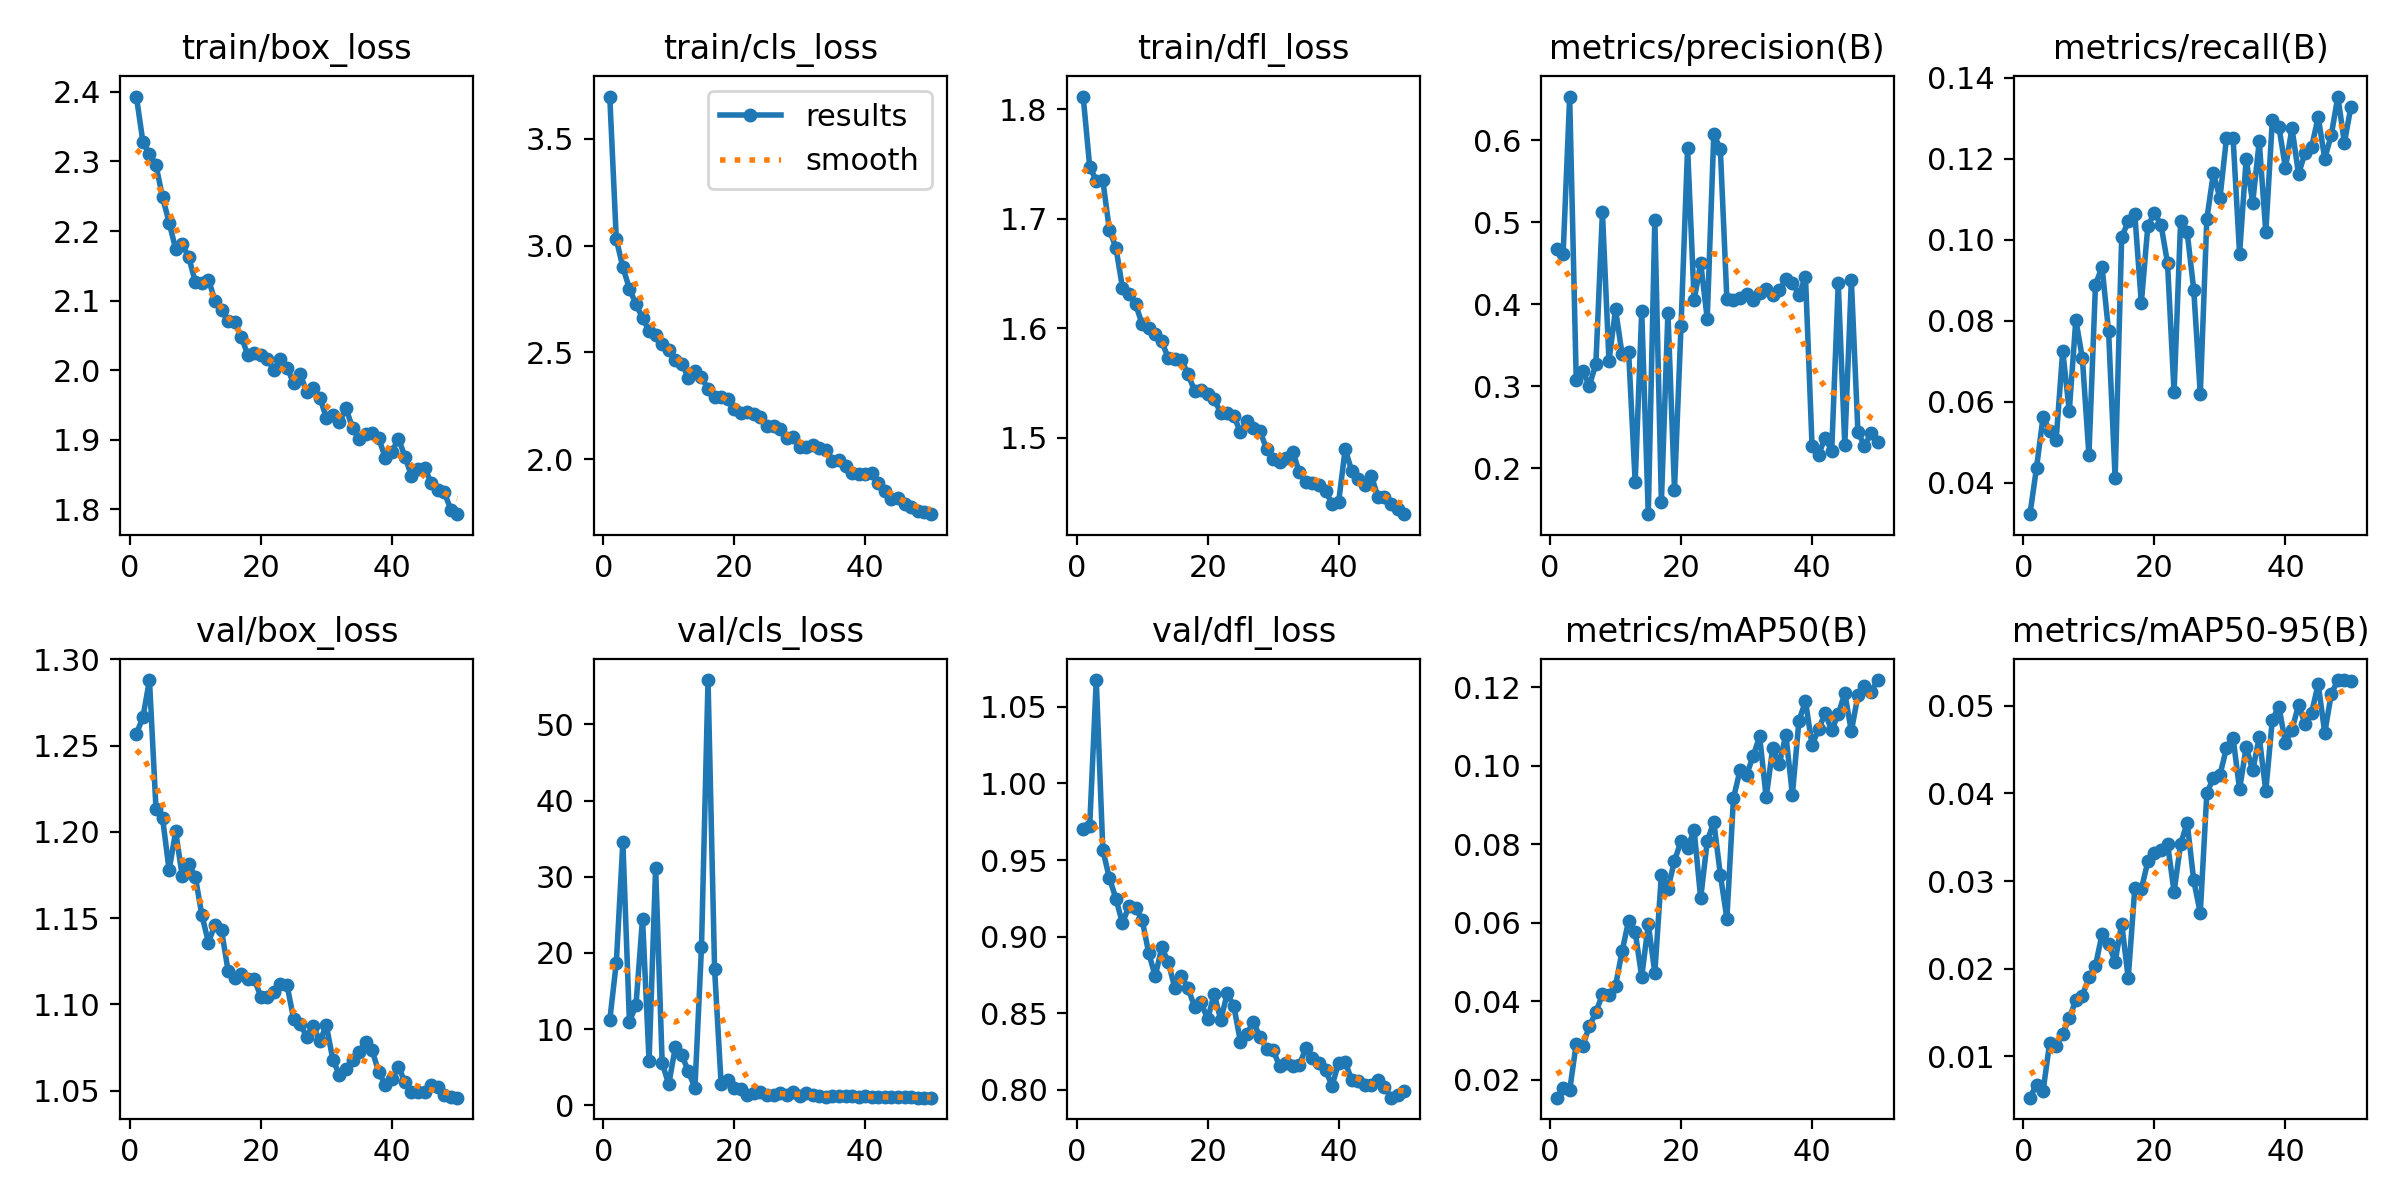

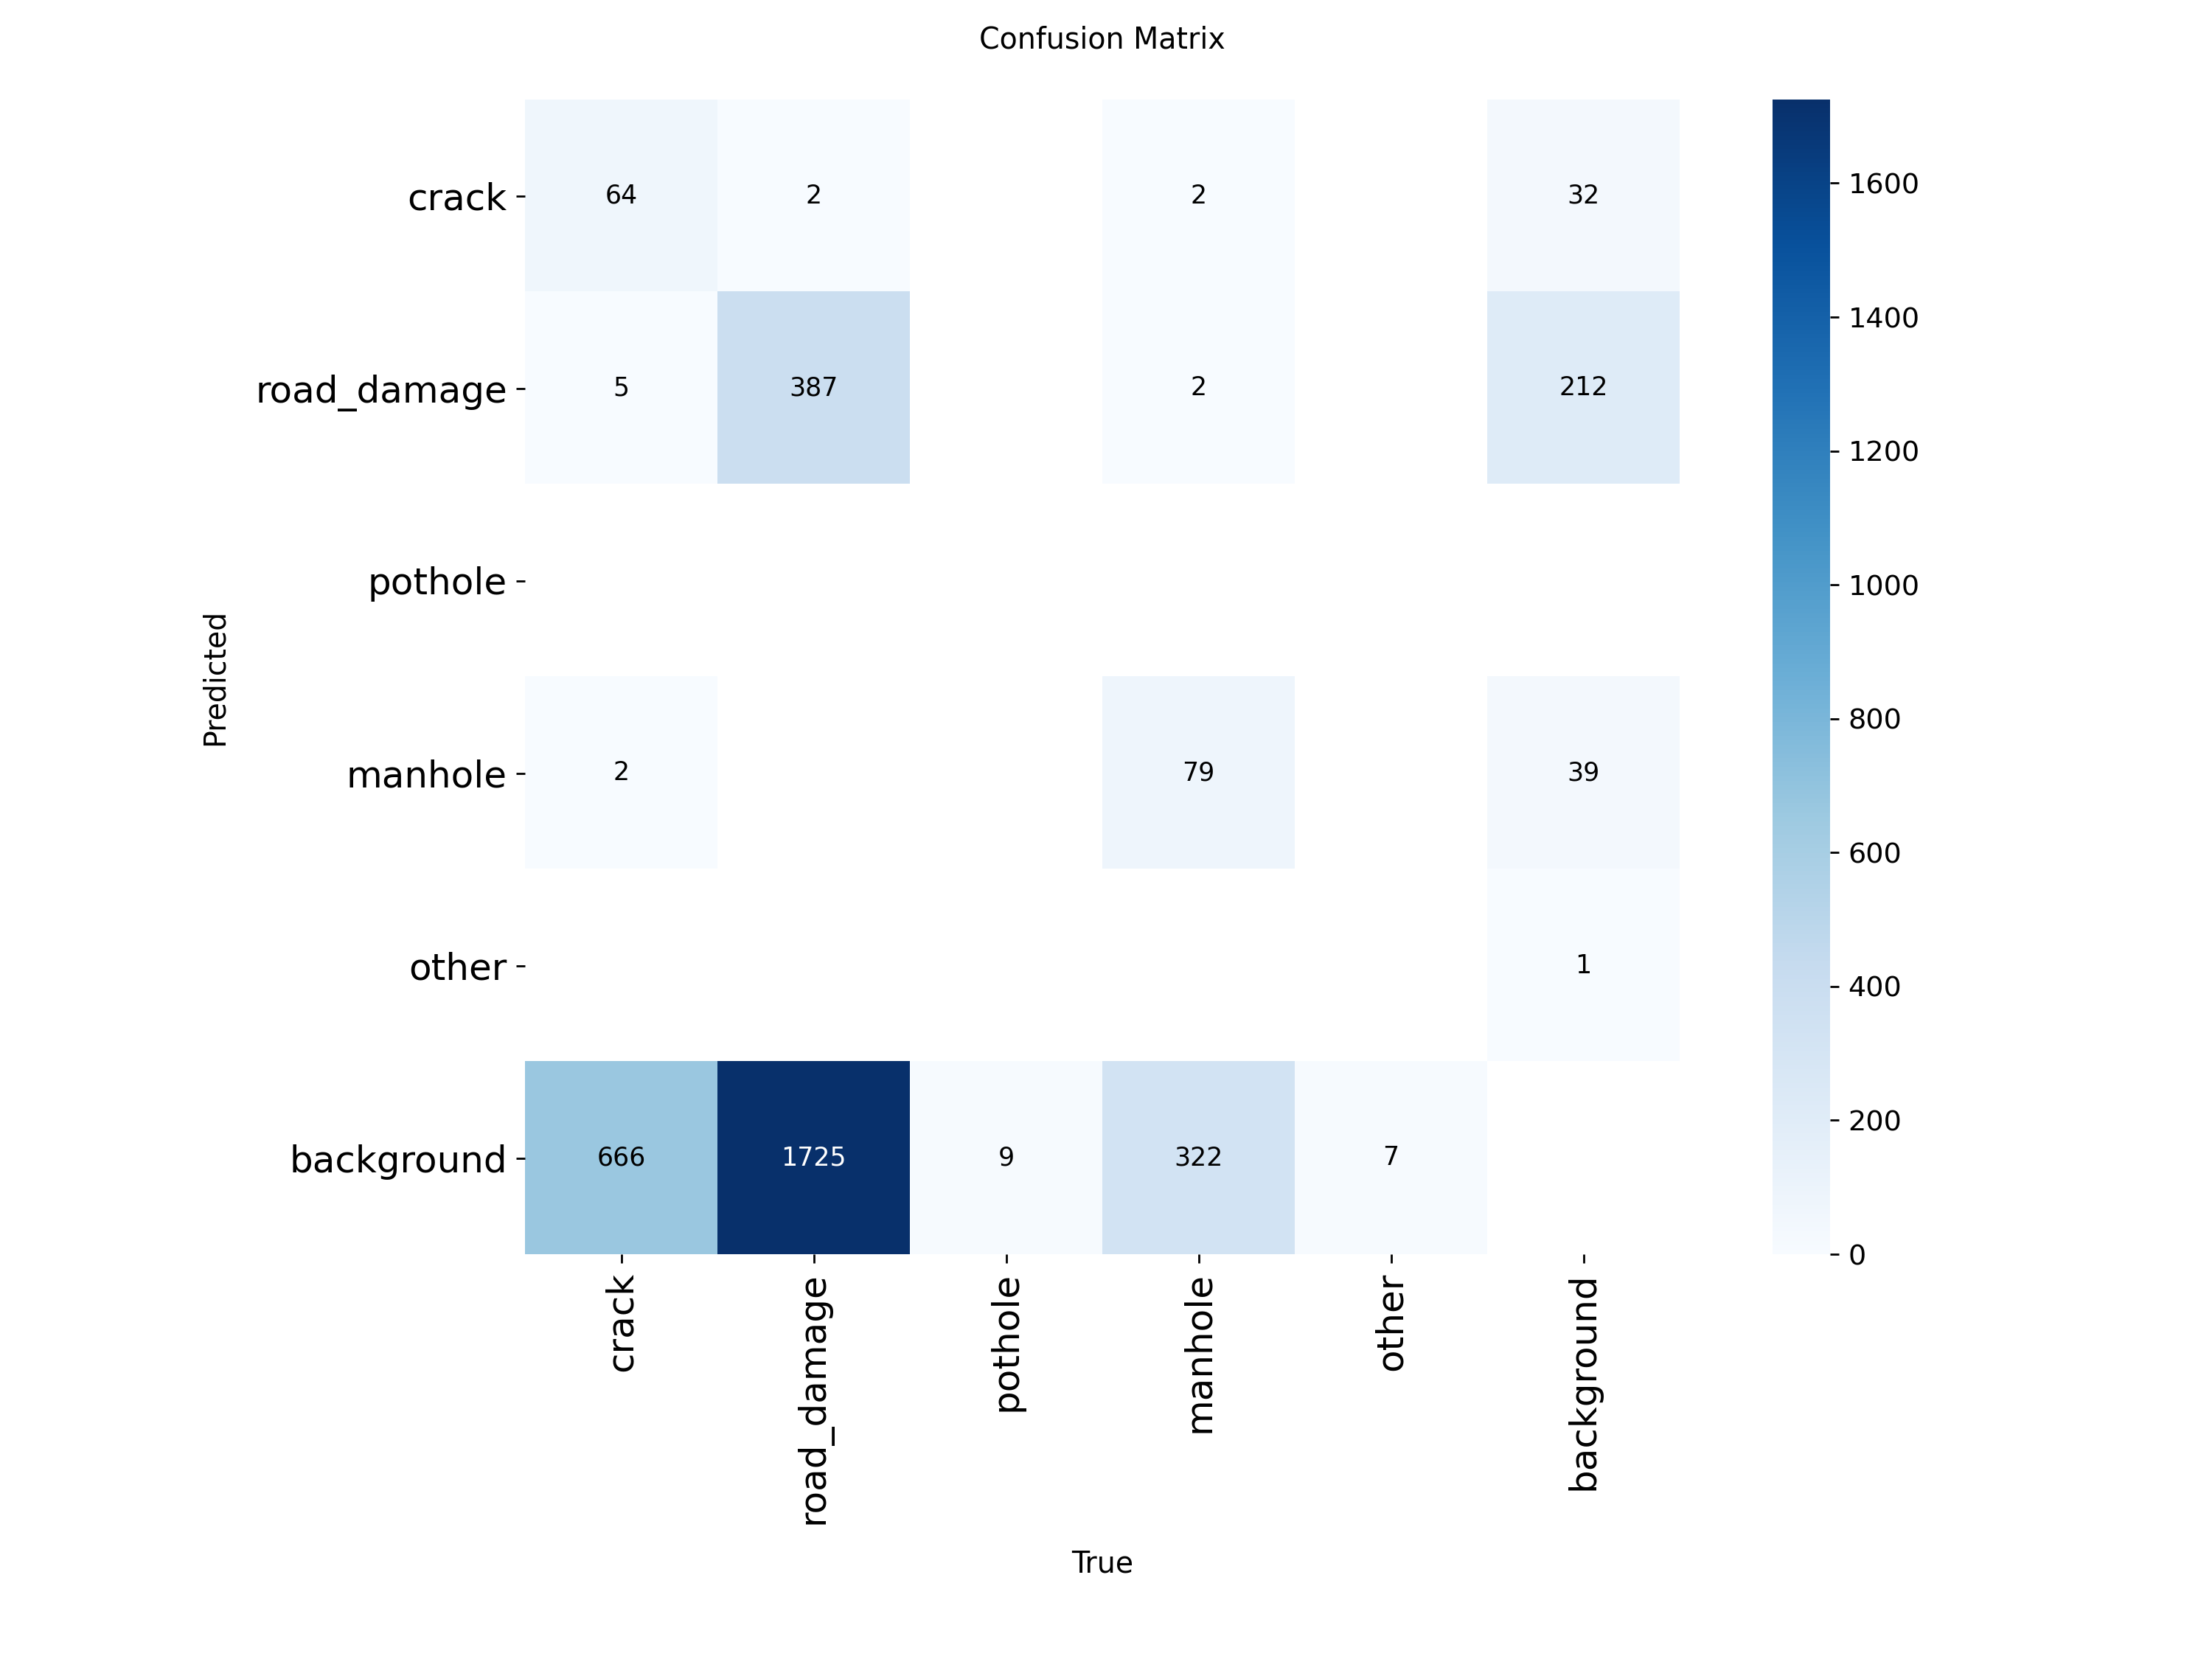

In [ ]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("runs/detect/runs/yolo_rdd/yolov8n_from_voc")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))


In [15]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
45,46,714.008,1.83864,1.79200,1.44634,0.42903,0.12006,0.10880,0.04689,1.05342,1.07158,0.80613,0.000121,0.000121,0.000121
46,47,729.216,1.82788,1.77546,1.44639,0.24467,0.12586,0.11791,0.05133,1.05230,1.03315,0.80187,0.000099,0.000099,0.000099
47,48,744.444,1.82503,1.75746,1.43968,0.22704,0.13535,0.12028,0.05290,1.04758,1.00912,0.79481,0.000077,0.000077,0.000077
48,49,759.701,1.79991,1.75274,1.43489,0.24254,0.12393,0.11879,0.05291,1.04612,1.01506,0.79658,0.000055,0.000055,0.000055
49,50,774.971,1.79326,1.74298,1.43038,0.23212,0.13288,0.12184,0.05276,1.04586,0.99750,0.79914,0.000033,0.000033,0.000033


In [16]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.2321
Recall:    0.1329
mAP@0.5:   0.1218
mAP@0.5:0.95: 0.0528


# Yolov8s 140 epochs

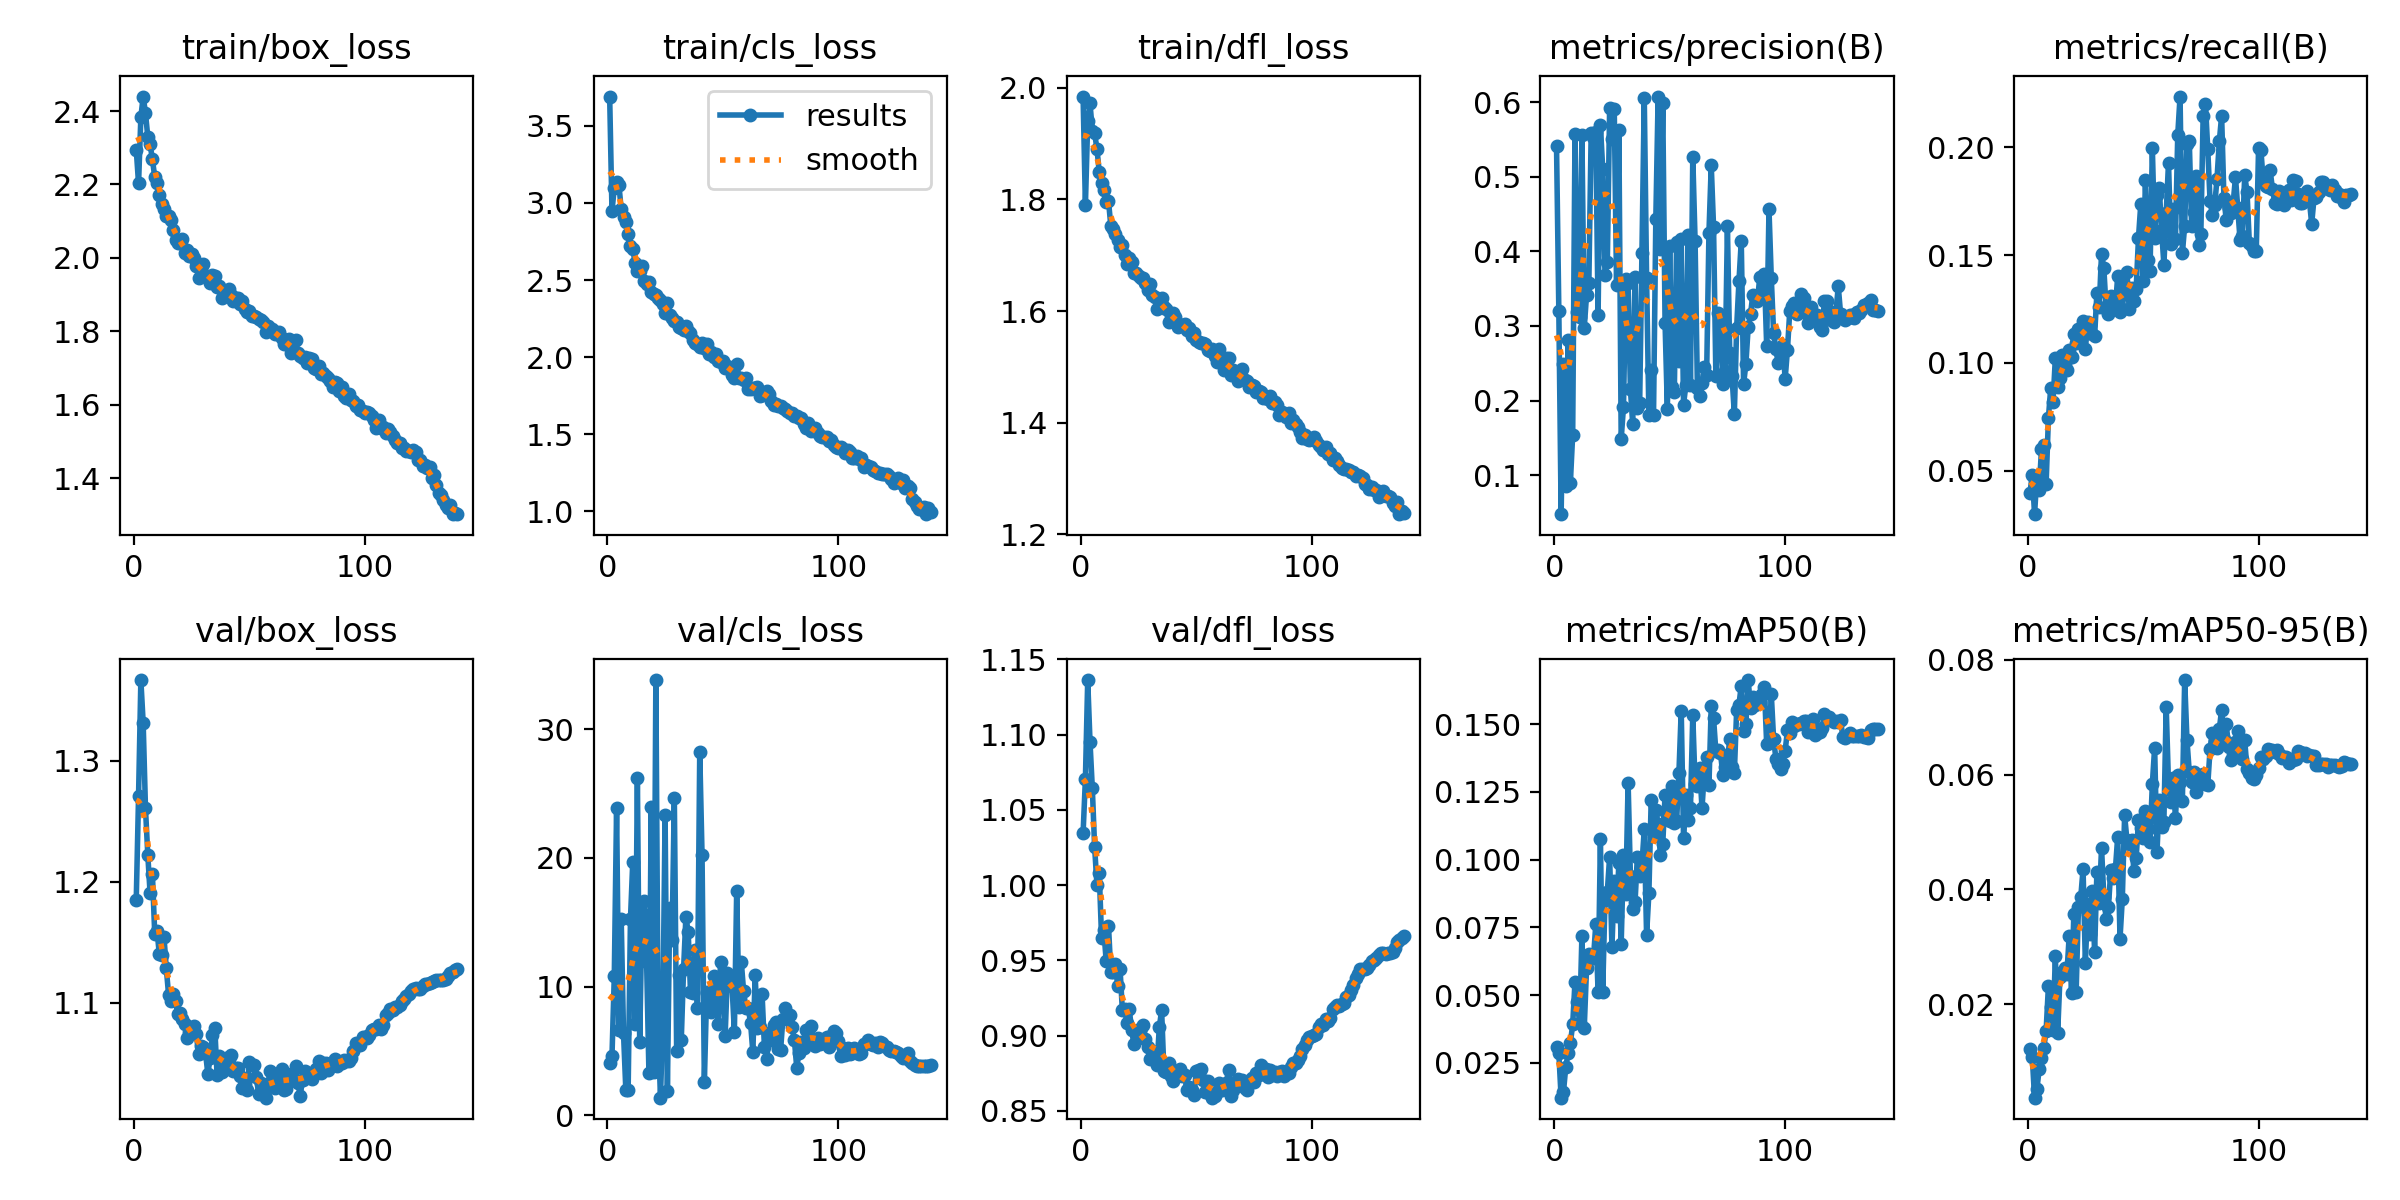

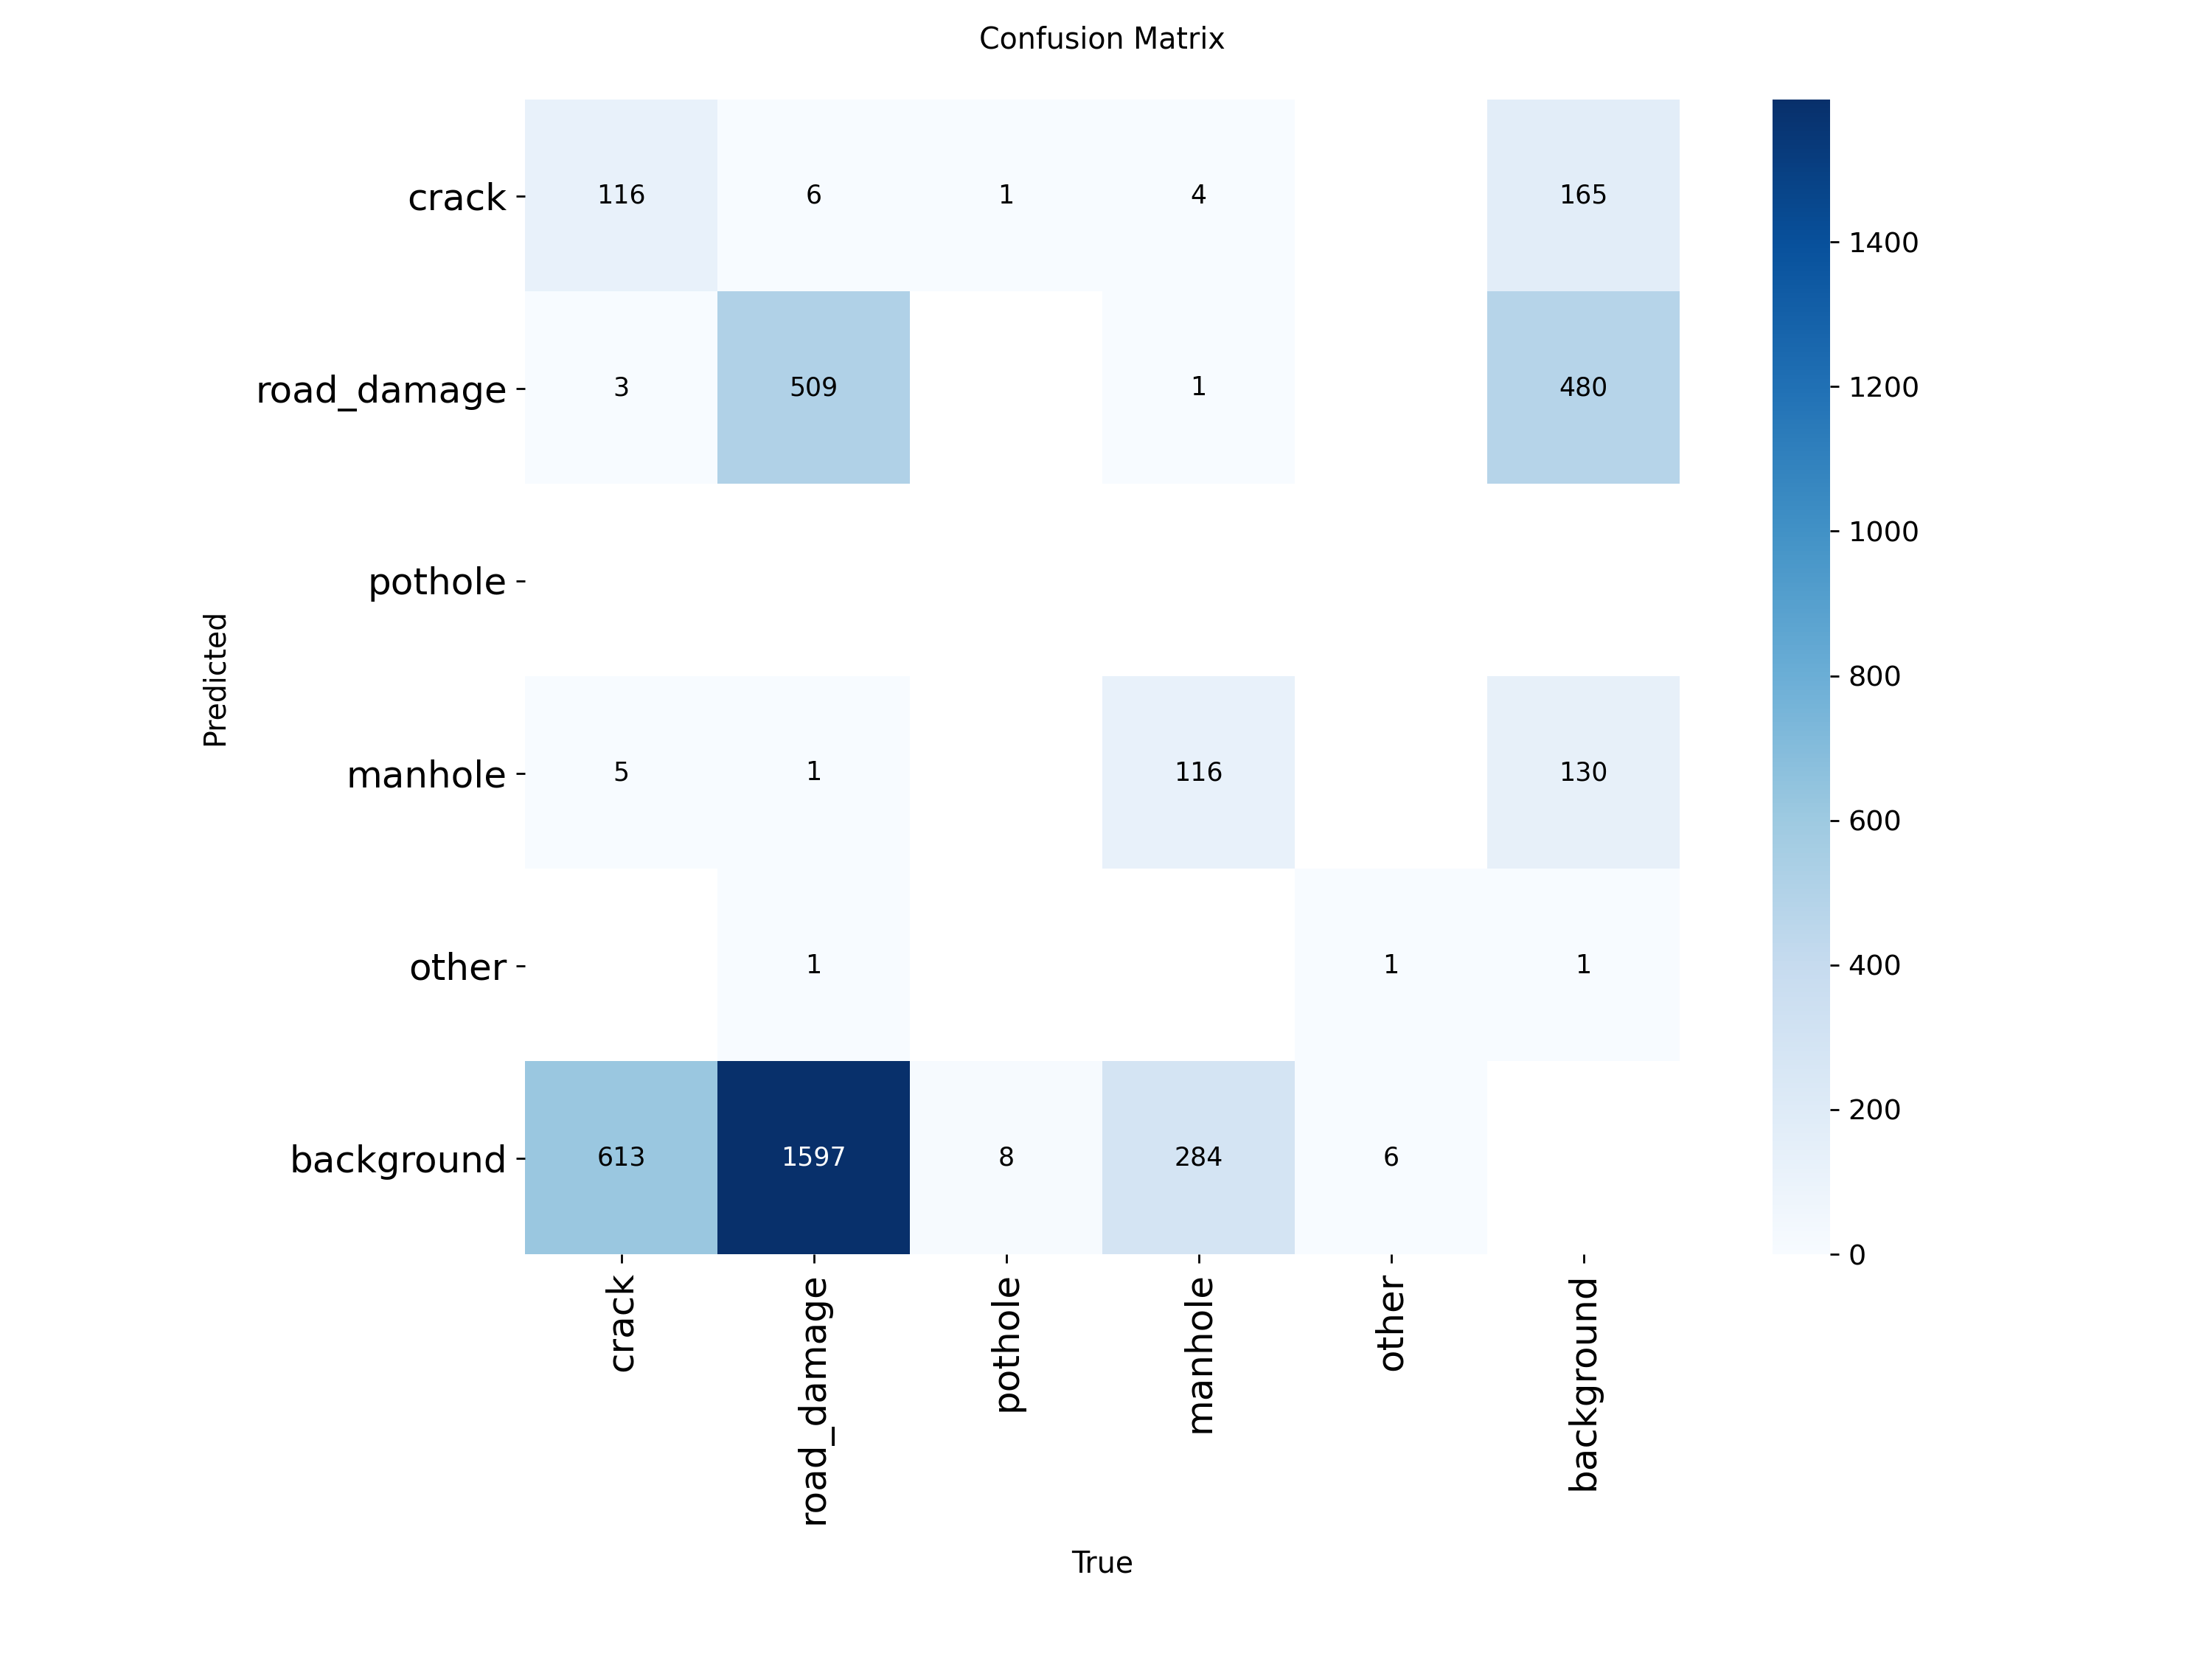

In [21]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("runs/detect/runs/yolo_rdd/yolov8s_from_voc")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))


In [22]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
135,136,5449.93,1.31697,1.01491,1.25047,0.33012,0.17627,0.14494,0.06145,1.12168,3.79491,0.95850,0.001361,0.000454,0.001361,0.000454,0.001361,0.000454,0.001361,0.000454
136,137,5489.68,1.32614,1.02865,1.25761,0.33520,0.17454,0.14796,0.06217,1.12456,3.81568,0.96227,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383
137,138,5529.57,1.30148,0.98198,1.23622,0.32142,0.17792,0.14812,0.06201,1.12563,3.84811,0.96378,0.000936,0.000312,0.000936,0.000312,0.000936,0.000312,0.000936,0.000312
138,139,5569.39,1.30451,1.02072,1.24229,0.32137,0.17780,0.14834,0.06190,1.12685,3.81846,0.96492,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241
139,140,5609.20,1.30143,0.99468,1.23895,0.31962,0.17841,0.14839,0.06188,1.12791,3.87769,0.96600,0.000512,0.000171,0.000512,0.000171,0.000512,0.000171,0.000512,0.000171


In [23]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.3196
Recall:    0.1784
mAP@0.5:   0.1484
mAP@0.5:0.95: 0.0619
